# Example of learning recurrent weights for a 2-D signal

## To-Do:

   * Fixed optimal balanced network and neuron death
   * Learning recurrent connectivity in loosely balanced networks
   * Neuron death and recurrent plasticity

In [1]:
import numpy as np
import numpy.random as rand
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
%matplotlib inline
VERBOSE = False                     # printout

NameError: name 'N' is not defined

In [2]:
def multiplot(ax,x,arr):
    if len(arr) > 10:
        colors = plt.get_cmap('rainbow', len(arr))
    else:
        colors = list(bcolors.values())
    for i, y in enumerate(arr):
        if len(arr) > 10:
            ax.plot(x, y, '-', c=colors(i))
        else:
            ax.plot(x, y, '-', c=colors[i])
    return ax

def rasterplot(ax, spikes):
    N = len(spikes)
    if N > 10:
        colors = plt.get_cmap('rainbow', N)
    else:
        colors = list(bcolors.values())
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        if N > 10:
            ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors(neuron))
        else:
            ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors[neuron])
    ax.set_ylim([0, N+1])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax

In [3]:
def get_oscillat_input(time, ampl, freq, offs, noise_var = 0.0):
    ampl = ampl*np.ones(2) if isinstance(ampl, float) else ampl
    freq = freq*np.ones(2) if isinstance(freq, float) else freq
    offs = offs*np.ones(2) if isinstance(offs, float) else offs
    x       = np.zeros((2,len(time)))             # define input array
    x[:,:]  = [ ampl[0] * np.cos(freq[0]*time) + offs[0],  
                ampl[1] * np.sin(freq[1]*time) + offs[1]]  # periodic signal (2D circle)
    x[:,0]  = 0                                   # initial values
    x      += noise_var*rand.randn(2,len(time)) # adding zero-mean white noise
    return x

In [4]:
def ablate_neuron(neuron, ts, F, W, V):
    """ Ablate i-th neuron at time step ts """
    print("Ablate neuron", neuron)
    F[neuron,:]  = 0
    W[neuron,:]  = 0
    W[:,neuron]  = 0
    V       = 0. 
    return F, W, V

In [85]:
def run(N, time, signal=0.0):
    """ This function simulates an N-dim. network for a given time
    
        RETURNS
        o      === spike trains of each neuron               || (nparray)
        V      === membrane potentials of each neuron        || (nparray)
        y      === spike trains of each neuron               || (nparray)
        r      === firing rates                              || (nparray)
        F      === feed-forward weights (fixed)              || (nparray)
        W      === recurrent weights (adapted)               || (nparray)
        Wo     === initial recurrent weights                 || (nparray)
        dW     === change of recurrent weights               || (nparray)
        W_all  === all recurrent weights for video           || (nparray)
        D      === decoding weights (fixed)                  || (nparray)
        
        ARGS
        N      === number of neurons in network              || (int)
        time   === time array                                || (nparray)
        signal === input (default:0.0)                       || (float/nparray)
        
    """
    
    ### Quick options
    _LEARNING = False                                        # use learning for recurrent & feed-forward weights
    _LEARNREC = False                                        # use learning only for recurrent weights
    _COST     = False                                        # use quadratic cost term
    _OPTI_REC = True                                         # use optimal weights for recurrent conn. (W = FD)
    
    
    ### input dim (fixed=2) and time
    M  = 2                                                   # input dims
    dt = time[1]-time[0]                                     # integration time step
    T  = dt*len(time)                                        # total duration
    
    
    ### state containers
    V  = np.zeros((N,len(time)))                             # membrane potential
    o  = np.zeros((N,len(time)))                             # spike trains
    r  = np.zeros((N,len(time)))                             # firing rates
    y  = np.zeros((M,len(time)))                             # readout
    st = []                                                  # spike times + index    
    
    
    ### input from args
    x  = signal                                              # input signal
    if isinstance(x, float):                                 # if float is given
        x *= np.ones((M,len(time)))                          # make sure input is correct dims
    
    
    ### network weights and firing threshold
    angles  = np.linspace(0, 2*np.pi, num=N, endpoint=False) # angles in [0,2PI) equally spaced
    angles += 0.00*2.*np.pi*rand.randn(N)
    
    ## FEED-FORWARD
    F       = np.array([np.cos(angles),np.sin(angles)]).T    # feed-forward connections
    F      *= 1.0                                            # scaling
    Fo      = np.copy(F)                                     # initial feed-forward weights
    
    ## RECURRENT
    mu      = 0.000001/N if _COST else 0.0                   # regularization constant (e-6)
    rvec    = rand.rand(N,1)                                 # uniformly distributed random vector
    #Wransym = rvec.dot(rvec.T)                              # random recurrent connections (symmetric)
    Wrand   = rand.randn(N,N)/(N)                            # random recurrent connections (non-symmetric)
    Wopt    = F.dot(F.T) + mu * np.eye(N)                    # optimal weights
    W       = np.zeros((N,N))
    W       = Wopt if _OPTI_REC else Wrand                   # choosing recurrent weights
    W      *= 1.                                             # scaling
    Wo      = np.copy(W)                                     # initial recurrent weights
    dW      = np.zeros((N, len(time)))                       # weight change vector
    W_all   = np.zeros((len(time),N,N))                      # container for all recurrent weights over time (video)
    
    ## DECODING
    D       = np.zeros((M,N))                                # decoder weights
    d1      = np.zeros((M,N))            
    d2      = 0.0
    
    
    ### constant parameters
    Thr     = np.diag((F).dot(F.T))/2 + (mu/2)*np.ones(N)    # thresholds
    #Thr     = np.diag(W)/2 + (mu/2)*np.ones(N)    # threshold
    #Thr     = 0.5*np.ones(N)
    beta1   = 2*Thr - mu * np.ones(N)  
    leak = 1.                                                # leak constant
    etaW = 0.01 if _LEARNING or _LEARNREC else 0.0           # learning rate for recurrent weights (0.01 worked)
    etaF = 0.0001 if _LEARNING and not _LEARNREC else 0.0    # learning rate for feed-forward weights
    
    if VERBOSE:
        evals, evecs = LA.eigh(W)
        print("Feed-forward weights:", F)
        print("Recurrent weights:", W)
        print("Spectral radius:", evals)
        print("Threshold:", Thr)
     
    ### ablations
    nabl    = 4                                              # number of ablations
    tabl    = 1000.                                          # start of ablations
    ablen   = 0.5                                            # duration of ablations
    ablate_t= (np.arange(tabl, tabl+ablen, ablen/nabl))/dt        # ablation times (start at halftime in short window)
    ablate_t= ablate_t.astype(int)
    #ablate_t = []#[int(45.)/dt]
    if VERBOSE:
        print("Ablations at t=", ablate_t*dt,"secs.")
    ablated = []
    to_ablate = []
    
    ### initial values
    V[:,0]  = -Thr
    #r[0,:] = x[0,0]
    #r[1,:] = x[1,0]/ np.sin(angles[1])
    
    ### running simulation
    print("Start simulation for", time[-1]+time[1],"seconds.")
    for i,t in enumerate(time[:-1]):
        
        ## storing weights
        W_all[i] = W
        
        ## ablations
        for ind, times in enumerate(ablate_t):
            if i == times:
                if len(to_ablate)==0:
                    rand_neuron = rand.randint(N)
                    while rand_neuron in ablated:
                        rand_neuron = rand.randint(N)
                else:
                    if ind < len(to_ablate):
                        rand_neuron = to_ablate[ind]
                if rand_neuron not in ablated:
                    F, W, V[:,i] = ablate_neuron(rand_neuron,i, F, W, V[:,i])
                    ablated.append(rand_neuron)
        
        ## input update
        c = x[:,i] + (x[:,i+1]-x[:,i])/dt                                      # neural input
        
        ## membrane potential update
        dV       = -V[:,i] + F.dot(c) - W.dot(o[:,i])                          # ODE membrane potential
        V[:,i+1] = V[:,i] + dt*leak*dV                                         # Euler integration
        #V[:,i+1] = np.clip(V[:,i+1], -10*Thr, np.inf)                          # clip membrane potential
        
        ## spikes update
        o[:,i+1] = (V[:,i+1] > Thr)                                            # check for spikes
        if np.sum(o[:,i+1])>0:
            special_flake = rand.choice(np.ravel(np.nonzero(o[:,i+1])), 1)[0]  # look who's a special flake...
            o[:,i+1]      = np.eye(N)[special_flake]/dt                        # only one spike per time step
            st.append([t, special_flake])
            
            ## weight update only if spike
            #beta = beta1/(2.*(Thr + mu * np.mean(r[:,:i],axis=1)))
            #dW[:,i] = beta*(V[:,i+1]+mu*r[:,i])
            #dW[:,i] = dW[:,i] - W[:,special_flake] 
            #dW[:,i] = dW[:,i] + mu*np.eye(N)[special_flake]                   #cost learning rule for
            if len(st) > 100 and _LEARNING:                                    # start learning after 100 spikes
                dW[:,i] = 2*V[:,i+1] - W[:,special_flake]                      # learning rule for
                #W[i+1,:,:] = W[i,:,:]
                W[:,special_flake] += etaW * dW[:,i]                           # adapting recurrent weights 
              
        ## firing rates update
        dr       = -r[:,i] + o[:,i+1]                                          # ODE firing rates
        r[:,i+1] = r[:,i] + dt*leak*dr                                         # Euler integration
        
        ## decoding averages
        #d1 += x[:,i]*r[:,i+1].T
        #d2 += r[i,tstart:tend]*np.sum(r[:,tstart:tend])
        
        ## regular printouts (every 10%)
        if math.fmod(100*t/T,10)==0:
            print(int(100*t/T), "%\t", "t:",t, "s")
            
    
    ### Calculate optimal decoding weights
    tstart = int(0./dt)
    tend = int(T/dt)
    for i in range(N):
        d1 = np.mean(x[:,tstart:tend]*r[i,tstart:tend], axis=1)
        d2 = np.mean(r[i,tstart:tend]*np.sum(r[:,tstart:tend], axis=0))
        if d2 == 0:
            D[:,i] = 0
        else:
            D[:,i] = N*d1/d2   ### tried N/2 before
            #D[:,i] = 8.*d1/d2
            
    ### Alternative: decoding matrix from pseudoinv(F)*W
    Finv1 = LA.pinv(Fo)
    Finv2 = LA.pinv(F)
    htime = int(tabl/dt)
    #D = F.T
            
    ### Calculate readouts
    if htime < T: 
        D1 = np.dot(Finv1,W_all[htime])
        D2 = np.dot(Finv2,W)
        y[:,:htime]   = D1.dot(r[:,:htime])
        y[:,htime+1:] = D2.dot(r[:,htime+1:])
    else:
        D  = np.dot(Finv2,W)
        D  = F.T
        y  = D.dot(r)
        
        
    ### Return
    print(100, "%\t", "t:",T, "s")
    print("Done.")
    return o, V, y, r, F, Fo, W, Wo, dW, W_all, D 

In [112]:
### simulation parameter
N    = 16                  # number of neurons
T    = 100.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array

### generate input signal
ampl = 5.
#circ = get_oscillat_input(time, ampl, 1., 0.)                               # Circle
circ = get_oscillat_input(time, ampl, np.array([1.,2.]), 0.)                 # Narrow eight
#circ = get_oscillat_input(time, np.array([ampl,0.5*ampl]), np.array([1.,2.]), 0.) # Wide eight
#circ = get_oscillat_input(time, np.array([0.,5.]), np.array([1.,2.]), 0.)  # Line

### run simulation
spikes, volt, readout, rates, ffW, ffWo, recW, Wo, dW, allW, decW = run(N, time, circ)

Start simulation for 100.0 seconds.
0 %	 t: 0.0 s
10 %	 t: 10.0 s
20 %	 t: 20.0 s
30 %	 t: 30.0 s
40 %	 t: 40.0 s
50 %	 t: 50.0 s
60 %	 t: 60.0 s
70 %	 t: 70.0 s
80 %	 t: 80.0 s
90 %	 t: 90.0 s
100 %	 t: 100.0 s
Done.


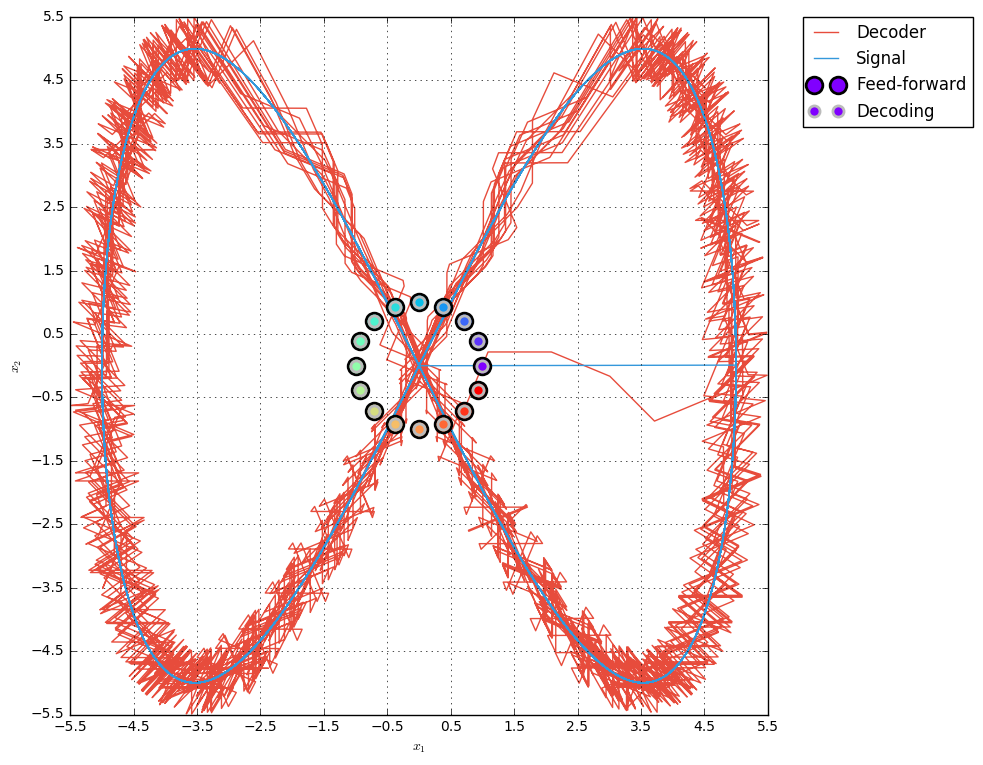

In [113]:
### base colors (flat ui)
bcolors = { 'alizarin'   : "#e74c3c",
            'peter_river': "#3498db",
            'emerald'    : "#2ecc71",
            'sunflower'  : "#f1c40f",
            'carrot'     : "#e67e22",
            'amethyst'   : "#9b59b6",
            'turquoise'  : "#1abc9c",
            'wet_asphalt': "#34495e",
            'pomegranate': "#c0392b",
            'belize_hole': "#2980b9"
        }
rcolors = plt.get_cmap('rainbow', N)

### Figure 1: input + readout in 2D
tabl    = 1000.                                          # start of ablations
which_period = 'all'
plen = 60.
periods = {'custom':  [0./dt,                      T/dt],
           'all':     [0./dt,                      T/dt],
           'initial': [0/dt,                    plen/dt], 
           'early':   [plen/dt,               2*plen/dt],
           'ablation':[(tabl-plen)/dt,   (tabl+plen)/dt],
           'mid':     [(T-plen)/(2*dt), (T+plen)/(2*dt)], 
           'late':    [(T-2*plen)/dt,       (T-plen)/dt],
           'end':     [(T-plen)/dt,                T/dt]}
plt_t0 = int(periods[which_period][0])
plt_t1 = int(periods[which_period][1])
fig, ax = plt.subplots(1, figsize=(9,9))
ax.plot(readout[0,plt_t0:plt_t1], readout[1,plt_t0:plt_t1], c=bcolors['alizarin'], label="Decoder")
ax.plot(circ[0,plt_t0:plt_t1], circ[1,plt_t0:plt_t1], c=bcolors['peter_river'], label="Signal")
for ind in range(N):
    if ind==0:
        ax.plot(ffW[ind,0], ffW[ind,1], 'o', mfc = rcolors(ind), mec='k', markersize=12, markeredgewidth=2, label='Feed-forward')
        ax.plot(decW[0,ind], decW[1,ind], 'o', mfc=rcolors(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2, label='Decoding')
    else:
        ax.plot(ffW[ind,0], ffW[ind,1], 'o', mfc = rcolors(ind), mec='k', markersize=12, markeredgewidth=2)
        ax.plot(decW[0,ind], decW[1,ind], 'o', mfc=rcolors(ind), mec='#bbbbbb', markersize=8, markeredgewidth=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
scale = ampl+0.5
ax.set_xlim([-scale,scale])
ax.set_ylim([-scale,scale])
tick=1
ax.set_xticks(np.arange(-scale,scale+tick,tick))
ax.set_yticks(np.arange(-scale,scale+tick,tick))
ax.grid()
#ax.axis('off')
plt.show()

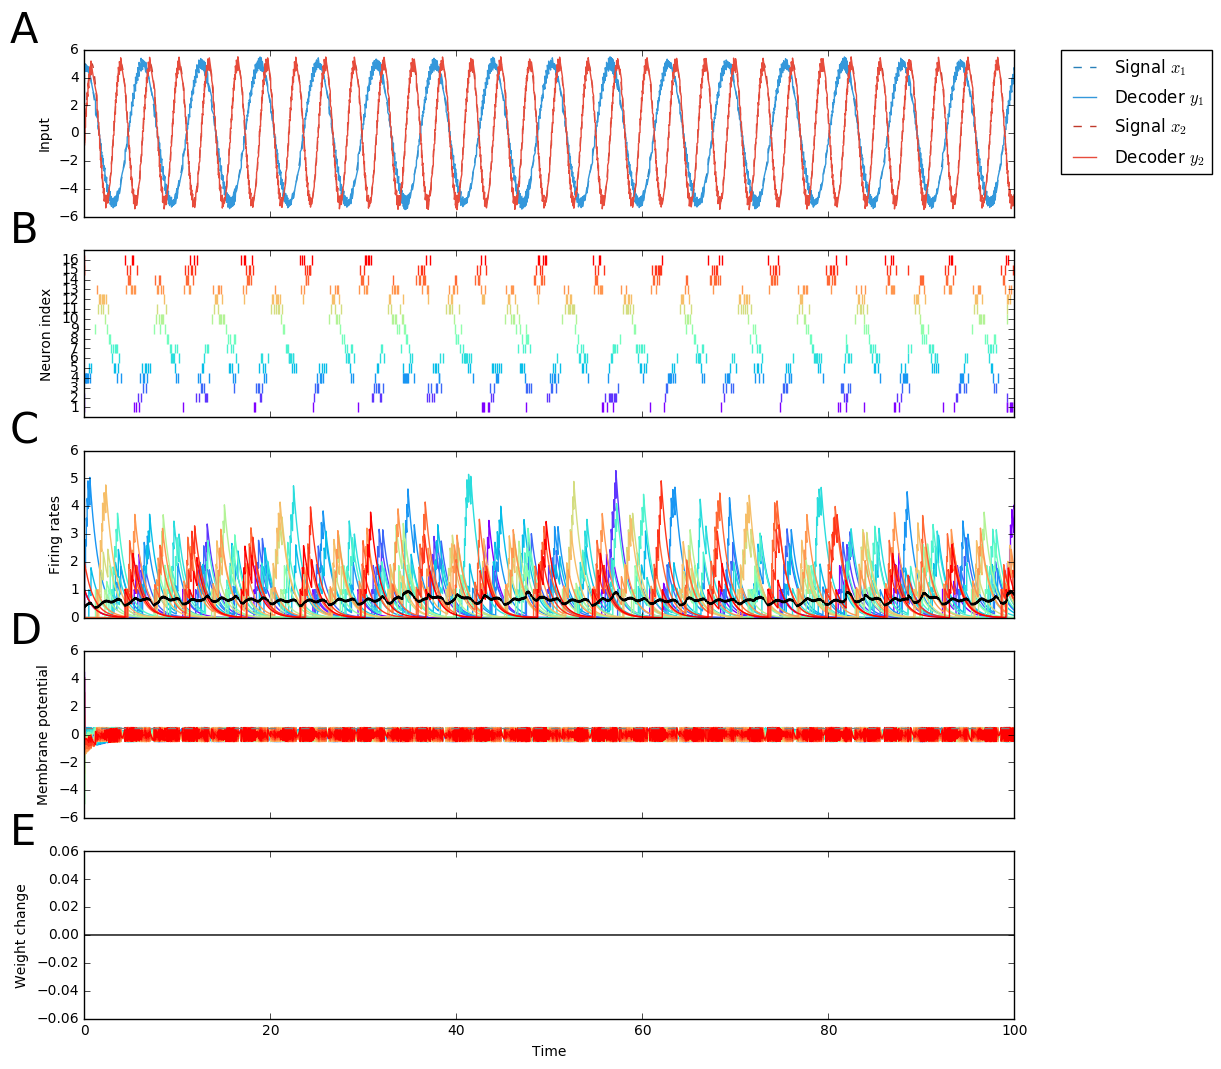

In [114]:
### Figure 2: time series
figs = 5
fig, axes = plt.subplots(figs, 1, figsize=(12,2.5*figs),sharex=True)

### additional measures
pop_rate = np.mean(rates,axis=0)  # population activity
pop_var  = np.var(rates,axis=0)   # population variance

#plt_t0 = int(894.925/dt)
#plt_t1 = int(894.931/dt)
### panel A: input time series
axes[0].plot(time[plt_t0:plt_t1], circ[0,plt_t0:plt_t1], "--" , c=bcolors['belize_hole'], label="Signal $x_1$")
axes[0].plot(time[plt_t0:plt_t1], readout[0,plt_t0:plt_t1], c=bcolors['peter_river'], label="Decoder $y_1$")
axes[0].plot(time[plt_t0:plt_t1], circ[1,plt_t0:plt_t1], "--", c=bcolors['pomegranate'], label="Signal $x_2$")
axes[0].plot(time[plt_t0:plt_t1], readout[1,plt_t0:plt_t1], c=bcolors['alizarin'], label="Decoder $y_2$")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_ylabel("Input")
axes[0].set_xlim([plt_t0*dt,plt_t1*dt])
### panel B: spike raster plot
axes[1] = rasterplot(axes[1], spikes*dt)
axes[1].set_xlim([plt_t0*dt,plt_t1*dt])
### panel C: rates time series
axes[2] = multiplot(axes[2], time, [rate for rate in rates])
axes[2].plot(time, pop_rate, "k-")
#axes[2].plot(time, pop_var, "y-")
axes[2].set_ylabel("Firing rates")
axes[2].set_xlim([plt_t0*dt,plt_t1*dt])
#axes[2].set_ylim([0.0, 10.])
### panel D: membrane potential time series
axes[3] = multiplot(axes[3], time, [pot for pot in volt])
axes[3].set_ylabel("Membrane potential",fontsize=10)
axes[3].set_xlim([plt_t0*dt,plt_t1*dt])
maxV = np.amax(volt[:,plt_t0:plt_t1])
minV = np.amin(volt[:,plt_t0:plt_t1])
axes[3].set_ylim([1.05*minV, 1.05*maxV])
axes[3].set_ylim([-6, 6])
axes[3].plot([0, T], [0.5, 0.5],'--', c="gray")
### panel E: weight change time series
axes[4].plot(time, np.sum(dW, axis=0), "k-")
axes[4].set_xlabel("Time")
axes[4].set_ylabel("Weight change")
axes[4].set_xlim([plt_t0*dt,plt_t1*dt])

panel = ["A","B","C","D","E","F"]
for i in range(figs):
    axes[i].set_title(panel[i], fontsize=figs*6, loc='left', x=-0.08)

plt.show()

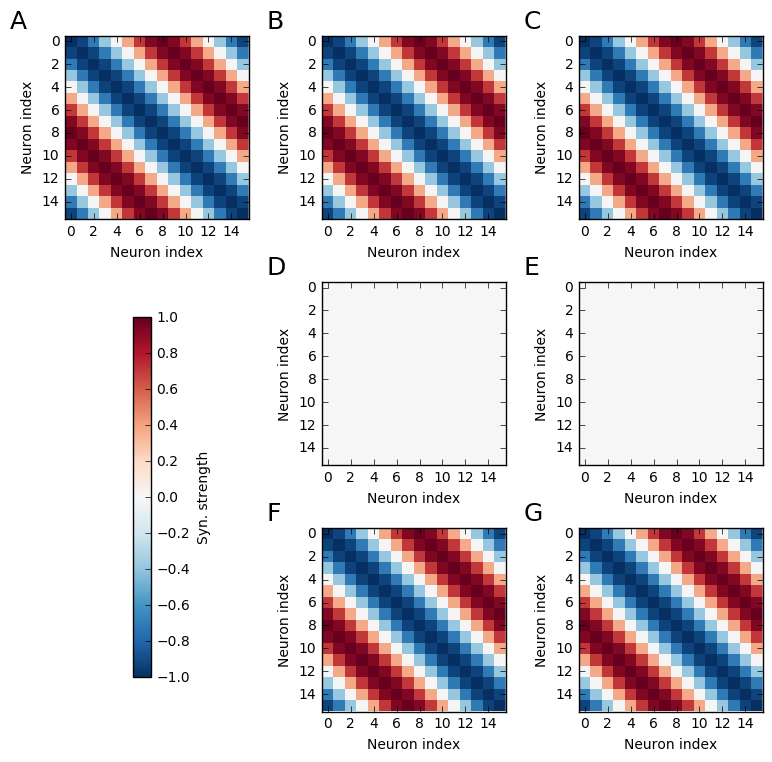

In [75]:
### Figure 3: recurrent weights
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(9,9))
Wopt1     = ffWo.dot(ffWo.T) + 0.000001/N * np.eye(N) # optimal weights before ablation
Wopt2     = ffW.dot(ffW.T) + 0.000001/N * np.eye(N)   # optimal weights after ablation
if int(tabl/dt)-1 < T:
    Wmid      = allW[int(tabl/dt)-1]                  # weight before ablation
else:
    Wmid  = recW
Wdiffmid  = Wmid-Wopt1                                # difference from optimality before ablation
Wdiff     = recW-Wopt2                                # difference from optimality after ablation

cbsc = 1. #np.max(Wdiff)
colmap = "RdBu_r"
### panel A: initial recurrent weights
im1 = axes[0,0].imshow(-Wo, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[0].axis('off')
axes[0,0].set_xlabel("Neuron index")
axes[0,0].set_ylabel("Neuron index")


### panel B: final recurrent weights before ablation
im2 = axes[0,1].imshow(-Wmid, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[0,1].set_xlabel("Neuron index")
axes[0,1].set_ylabel("Neuron index")

### panel C: final recurrent weights after ablation
im2 = axes[0,2].imshow(-recW, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[0,2].set_xlabel("Neuron index")
axes[0,2].set_ylabel("Neuron index")

### panel D: EMPTY (colorbar)
im2 = axes[1,0].imshow(np.zeros((N,N)), cmap="Greys")
axes[1,0].axis('off')
axes[1,0].set_xlabel("Neuron index")
axes[1,0].set_ylabel("Neuron index")

### panel E: difference to optimal weights before ablation
im2 = axes[1,1].imshow(Wdiffmid, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[1,1].set_xlabel("Neuron index")
axes[1,1].set_ylabel("Neuron index")

### panel F: difference to optimal weights after ablation
im2 = axes[1,2].imshow(Wdiff, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[1,2].set_xlabel("Neuron index")
axes[1,2].set_ylabel("Neuron index")

### panel G: EMPTY
im2 = axes[2,0].imshow(np.zeros((N,N)), cmap="Greys")
axes[2,0].axis('off')
axes[2,0].set_xlabel("Neuron index")
axes[2,0].set_ylabel("Neuron index")

### panel H: final recurrent weights before ablation
im2 = axes[2,1].imshow(-Wopt1, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[2,1].set_xlabel("Neuron index")
axes[2,1].set_ylabel("Neuron index")

### panel I: final recurrent weights after ablation
im2 = axes[2,2].imshow(-Wopt2, cmap=colmap, vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[2,2].set_xlabel("Neuron index")
axes[2,2].set_ylabel("Neuron index")

cbaxes = fig.add_axes([0.2, 0.175, 0.02, 0.4]) 
fig.colorbar(im1, ax=axes[0,0], cax = cbaxes, label="Syn. strength")

panel = ["A","B","C","","D","E","","F","G","H","I"]
for i, ax in enumerate(np.ravel(axes)):
    ax.set_title(panel[i], fontsize=18, loc='left', x=-0.3)

plt
plt.subplots_adjust(wspace=0.4)
plt.show()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
Mean scaling: 1.0


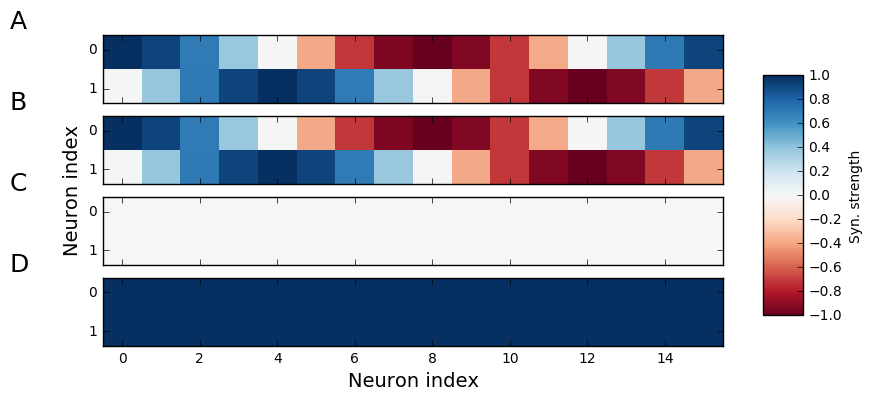

In [76]:
### Figure 4: decoding weights
figs = 4
fig, axes = plt.subplots(figs, 1,sharex=True, figsize=(8,figs*1))
Dopt       = ffWo.T

cbsc = 1
### panel A: decoding weights
im1 = axes[0].imshow(decW, cmap="RdBu", vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[0].axis('off')
#axes[0].set_xlabel("Neuron index")
#axes[0].set_ylabel("Neuron index")


### panel B: optimal decoding weights
im2 = axes[1].imshow(Dopt, cmap="RdBu", vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
#axes[1].set_xlabel("Neuron index")
axes[1].set_ylabel("Neuron index", fontsize=14,y=-0.1)

### panel C: weight difference
im2 = axes[2].imshow(decW-Dopt, cmap="RdBu", vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
#axes[2].set_xlabel("Neuron index", fontsize=14)
#axes[2].set_ylabel("Neuron index")

### panel D: weight scaling
Dscale = Dopt/decW
Dscale[np.isnan(Dscale)] = 1.
print(Dscale)
print("Mean scaling:", np.mean((Dscale)))
im2 = axes[3].imshow(Dscale, cmap="RdBu", vmin=-cbsc,vmax=cbsc, interpolation="none")
#axes[1].axis('off')
axes[3].set_xlabel("Neuron index", fontsize=14)
#axes[2].set_ylabel("Neuron index")

cbaxes = fig.add_axes([0.95, 0.2, 0.05, 0.6]) 
fig.colorbar(im1, ax=axes[0], cax = cbaxes, label="Syn. strength")

panel = ["A","B","C","D","E","F"]
for i, ax in enumerate(np.ravel(axes)):
    ax.set_title(panel[i], fontsize=18, loc='left', x=-0.15)
    ax.set_yticks([0,1])

#plt.subplots_adjust(wspace=0.4)
plt.show()

5000000
(16, 16)
1000
0
200
400
600
800


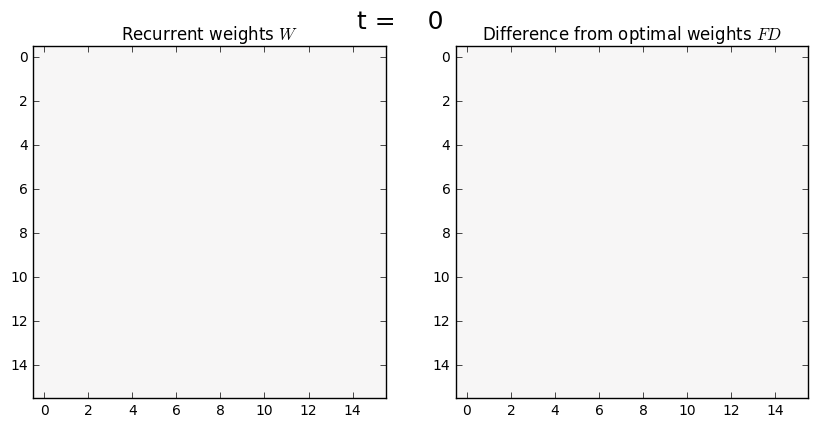

In [11]:
import matplotlib.image as img
from matplotlib import animation, rc
from IPython.display import HTML
from scipy import ndimage,misc

fig, ax = plt.subplots(1,2,figsize=(10,5))
print(len(allW))
print(allW[0].shape)
cbsc = 1
colmap = "RdBu_r"

skip = 5000     ##[ms]
reduce = 16
nallW = allW[::skip,:reduce,:reduce]

implot0 = ax[0].imshow((-nallW[0]), vmin=-cbsc, vmax=cbsc, cmap=colmap, animated=True, interpolation='none')
implot1 = ax[1].imshow((nallW[0]-Wopt1[:reduce,:reduce]), vmin=-cbsc, vmax=cbsc, cmap=colmap, animated=True, interpolation='none')
#implot2 = ax[2].imshow((y_low[:,10]).reshape(imgsize,imgsize), vmin=0.0, vmax=1.0, cmap="gray",animated=True, interpolation='none')
ax[0].set_title("Recurrent weights $W$") # $\mathbf{x}(t)$")
ax[1].set_title("Difference from optimal weights $FD$") # $\mathbf{x}(t)$")
#ax[2].set_title("Decoder y(t)") # $\mathbf{y}(t)$")
#for ind in range(3):
#    ax[ind].set_xticks(np.arange)
#    ax[ind].set_yticks([N])

time_template = 't = %4.0f'
time_text = ax[0].text(0.92, 1.05, '', fontsize=18, transform=ax[0].transAxes)

def init():
    implot0.set_data(np.zeros((N,N)))
    implot1.set_data(np.zeros((N,N)))
    time_text.set_text(time_template % (0*dt*skip))
    return [implot0, implot1, time_text]

def animate(i):
    new_W = -nallW[i]
    if i < tabl/(dt*skip):
        new_dW = (nallW[i]-Wopt1[:reduce,:reduce])
    else:
        new_dW = (nallW[i]-Wopt2[:reduce,:reduce])
    implot0.set_data(new_W)
    implot1.set_data(new_dW)
    fig.suptitle("", )
    if math.fmod(i,nallW.shape[0]/5)==0:
        print(i)
    time_text.set_text(time_template % (i*dt*skip))
    return [implot0, implot1, time_text]

print(nallW.shape[0])
nframes = nallW.shape[0]
vid_duration = 20.                                       # in secs
#FFMpegWriter = animation.writers['ffmpeg']

# Change the video bitrate as you like and add some metadata.
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=int(1*nframes), interval=vid_duration*(skip/nframes))
#plt.show() #, fps=100, writer=animation.FFMpegWriter(), codec="libx264", bitrate=-1, extra_args=['-pix_fmt', 'yuv420p']
ani.save('./videos/2D-recw-learn.mp4', dpi=300)


In [12]:
HTML(ani.to_html5_video())

0
200
400
600
800
